# Maestr√≠a en Inteligencia Artificial Aplicada 

## Curso: Proyecto Integrador (Grupo 10) 

## Avance 4. Modelos alternativos
<br />

### Profesor titular  
#### Dra. Grettel Barcel√≥ Alonso 
#### Dr. Luis Eduardo Falc√≥n Morales  
<br />

<table>
<tr>
    <th colspan="2">Equipo 19: Los Californios I</th>
</tr>
<tr>
    <td>Ernesto Zapata Garza</td><td>A00915255</td>
</tr>
<tr>
    <td>Rafael Garc√≠a Dom√≠nguez</td><td>A01328974</td>
</tr>
<tr>
    <td>Erik L√≥pez Hern√°ndez</td><td>A00458875</td>
</tr>
</table>
<br />

##### 25 de mayo de 2025

Este notebook construye, eval√∫a y compara al menos 6 modelos diferentes para predecir emociones narrativas en escenas del guion *Los Californios*. Tambi√©n se realiza el ajuste fino de los mejores modelos y se selecciona uno final basado en rendimiento, interpretabilidad y viabilidad.

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Instalaciones necesarias

In [2]:
!pip install spacy


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!python -m spacy download es_core_news_md

     ---------------------------------------- 0.0/42.3 MB ? eta -:--:--
      --------------------------------------- 1.0/42.3 MB 7.1 MB/s eta 0:00:06
     ---------- ---------------------------- 11.0/42.3 MB 36.2 MB/s eta 0:00:01
     -------------- ------------------------ 15.5/42.3 MB 30.4 MB/s eta 0:00:01
     ----------------- --------------------- 19.4/42.3 MB 26.6 MB/s eta 0:00:01
     ---------------------- ---------------- 24.9/42.3 MB 26.7 MB/s eta 0:00:01
     -------------------------- ------------ 28.8/42.3 MB 25.4 MB/s eta 0:00:01
     ------------------------------------ -- 40.1/42.3 MB 30.3 MB/s eta 0:00:01
     --------------------------------------  42.2/42.3 MB 28.6 MB/s eta 0:00:01
     --------------------------------------- 42.3/42.3 MB 27.2 MB/s eta 0:00:00
‚úî Download and installation successful
You can now load the package via spacy.load('es_core_news_md')



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!pip install transformers


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
!pip install torch


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
!pip install huggingface_hub[hf_xet]


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
!pip3 install emoji==0.6.0


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
!pip install deep-translator


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
!pip install sentence_transformers


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Construcci√≥n inicial del dataframe

In [10]:
# Importaci√≥n de librer√≠as
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pathlib import Path
import spacy

# Cargar modelo de NLP
nlp = spacy.load('es_core_news_md')

In [11]:
# Carga y limpieza del guion
ruta_guion = Path('../data/LosCaliforniosScript.txt')
with open(ruta_guion, encoding='utf-8') as f:
    guion_crudo = f.read()

# Separaci√≥n preliminar por escenas
escenas = re.split(r'\n\(\d+\)\s+(EXT\.|INT\.)', guion_crudo)
escenas = [e.strip() for e in escenas if len(e.strip()) > 100]

df = pd.DataFrame({'escena_texto': escenas})
df['num_palabras'] = df['escena_texto'].apply(lambda x: len(x.split()))
df.head()

escena_texto  num_palabras
0  Los Californios\n1\nAutor. Carlos Peralta D√°vi...          5665
1  DESIERTO DE SONORA Y ARIZONA ‚Äì AMANECER\n\nIm√°...           594
2  2465 34TH AVE, OAKLAND ‚Äì D√çA\n\n\nSOBREPUESTO\...          1069
3  MARKET STREET, SAN FRANCISCO - D√çA\nLa carreta...           187
4  CALIFORNIA STREET SAN FRANCISCO- D√çA\n\n\nLa c...            97

In [12]:
# Extracci√≥n de personajes con NLP
df['doc'] = df['escena_texto'].apply(nlp)
df['personajes'] = df['doc'].apply(lambda d: list(set([ent.text for ent in d.ents if ent.label_ == 'PER'])))

from collections import Counter

personajes_todos = df['personajes'].explode()
conteo_personajes = Counter(personajes_todos)

personajes_filtrados = [p for p, c in conteo_personajes.items() if c >= 5 and len (p.split()) <= 3]
df['personajes_filtrados'] = df['personajes'].apply(lambda lista: [p for p in lista if p in personajes_filtrados])

df[['escena_texto', 'personajes_filtrados']].head()

escena_texto  \
0  Los Californios\n1\nAutor. Carlos Peralta D√°vi...   
1  DESIERTO DE SONORA Y ARIZONA ‚Äì AMANECER\n\nIm√°...   
2  2465 34TH AVE, OAKLAND ‚Äì D√çA\n\n\nSOBREPUESTO\...   
3  MARKET STREET, SAN FRANCISCO - D√çA\nLa carreta...   
4  CALIFORNIA STREET SAN FRANCISCO- D√çA\n\n\nLa c...   

                                personajes_filtrados  
0  [De Anza, Nakai, Pablo, Peter, Aldara, Quer√©ta...  
1                                                 []  
2    [Pablo, San Antonio, Luis Mar√≠a, Peralta, Zoey]  
3                                       [Luis Mar√≠a]  
4                                                 []

## Clasificaci√≥n autom√°tica de emociones por escena

In [ ]:
from huggingface_hub import login
login('TOKEN')

In [14]:
from transformers import pipeline
from deep_translator import GoogleTranslator

emotion_classifier = pipeline('text-classification', model='j-hartmann/emotion-english-distilroberta-base', top_k=1, device=-1)
translator = GoogleTranslator(source='es', target='en')

def detectar_emocion(texto):
    try:
        oraciones = re.split(r'[.!?]', texto)
        entrada = ' '.join(oraciones[:5]).strip()[:300]
        entrada_en = translator.translate(entrada)
        result = emotion_classifier(entrada_en)
        return result[0][0].get('label', 'desconocido')
    except Exception as e:
        print(f'Error:', e)
        return 'desconocido'
    
df['emocion'] = df['escena_texto'].apply(detectar_emocion)
df[['escena_texto', 'emocion']].head()

Device set to use cpu


escena_texto  emocion
0  Los Californios\n1\nAutor. Carlos Peralta D√°vi...  neutral
1  DESIERTO DE SONORA Y ARIZONA ‚Äì AMANECER\n\nIm√°...    anger
2  2465 34TH AVE, OAKLAND ‚Äì D√çA\n\n\nSOBREPUESTO\...      joy
3  MARKET STREET, SAN FRANCISCO - D√çA\nLa carreta...      joy
4  CALIFORNIA STREET SAN FRANCISCO- D√çA\n\n\nLa c...     fear

## Clustering tem√°tico con Sentence Transformers

In [15]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

model = SentenceTransformer('distiluse-base-multilingual-cased-v1', device='cpu')
embeddings = model.encode(df['escena_texto'].tolist())
kmeans = KMeans(n_clusters=5, random_state=42)
df['tema_cluster'] = kmeans.fit_predict(embeddings)
df[['tema_cluster', 'escena_texto']].groupby('tema_cluster').head(1)

tema_cluster                                       escena_texto
0              3  Los Californios\n1\nAutor. Carlos Peralta D√°vi...
1              1  DESIERTO DE SONORA Y ARIZONA ‚Äì AMANECER\n\nIm√°...
3              2  MARKET STREET, SAN FRANCISCO - D√çA\nLa carreta...
14             4  FRENTE IGLESIA ‚Äì TUBAC SONORA ‚Äì D√çA\n\nSOBREPU...
18             0  CASA DE LA FAMILIA ‚Äì CONTINUA\n\n\nLa HIJA, es...

## Limpieza y tratamiento de valores nulos o at√≠picos

In [16]:
df['escena_text'] = df['escena_texto'].str.strip()
print('Valores nulos por columna: ')
print(df.isnull().sum())
df.fillna("desconocido", inplace=True)

Valores nulos por columna: 
escena_texto            0
num_palabras            0
doc                     0
personajes              0
personajes_filtrados    0
emocion                 0
tema_cluster            0
escena_text             0
dtype: int64


In [17]:
# Calcular datos necesarios para el dashboard

# Escenas por personaje (Top 10)
personajes_escenas = df['personajes_filtrados'].explode().value_counts().head(10)

# Emociones detectadas
emociones = df['emocion'].value_counts()

# Clusters tem√°ticos (si existe esa columna)
if 'tema_cluster' in df.columns:
    temas = df['tema_cluster'].value_counts().sort_index()
else:
    temas = pd.Series()


## Importaci√≥n de paquetes necesarios

In [18]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

## Generaci√≥n y codificaci√≥n de nuevas caracter√≠sticas

In [19]:
df = pd.concat([df, pd.get_dummies(df['emocion'], prefix='em')], axis=1)
df['num_personajes'] = df['personajes_filtrados'].apply(len)
df['escena_coral'] = (df['num_personajes'] > 1).astype(int)
df.head()

escena_texto  num_palabras  \
0  Los Californios\n1\nAutor. Carlos Peralta D√°vi...          5665   
1  DESIERTO DE SONORA Y ARIZONA ‚Äì AMANECER\n\nIm√°...           594   
2  2465 34TH AVE, OAKLAND ‚Äì D√çA\n\n\nSOBREPUESTO\...          1069   
3  MARKET STREET, SAN FRANCISCO - D√çA\nLa carreta...           187   
4  CALIFORNIA STREET SAN FRANCISCO- D√çA\n\n\nLa c...            97   

                                                 doc  \
0  (Los, Californios, \n, 1, \n, Autor, ., Carlos...   
1  (DESIERTO, DE, SONORA, Y, ARIZONA, ‚Äì, AMANECER...   
2  (2465, 34TH, AVE, ,, OAKLAND, ‚Äì, D√çA, \n\n\n, ...   
3  (MARKET, STREET, ,, SAN, FRANCISCO, -, D√çA, \n...   
4  (CALIFORNIA, STREET, SAN, FRANCISCO-, D√çA, \n\...   

                                          personajes  \
0  [De Anza, Nakai, Pablo, Mar√≠a Luisa Fermina Pe...   
1                                      [Californios]   
2  [34TH AVE, Robert, Pablo, Mar√≠a Alicia, San An...   
3  [Luis Mar√≠a, Distinguished Californian, Luis M...   
4                                                 []   

                                personajes_filtrados  emocion  tema_cluster  \
0  [De Anza, Nakai, Pablo, Peter, Aldara, Quer√©ta...  neutral             3   
1                                                 []    anger             1   
2    [Pablo, San Antonio, Luis Mar√≠a, Peralta, Zoey]      joy             3   
3                                       [Luis Mar√≠a]      joy             2   
4                                                 []     fear             2   

                                         escena_text  em_anger  em_disgust  \
0  Los Californios\n1\nAutor. Carlos Peralta D√°vi...     False       False   
1  DESIERTO DE SONORA Y ARIZONA ‚Äì AMANECER\n\nIm√°...      True       False   
2  2465 34TH AVE, OAKLAND ‚Äì D√çA\n\n\nSOBREPUESTO\...     False       False   
3  MARKET STREET, SAN FRANCISCO - D√çA\nLa carreta...     False       False   
4  CALIFORNIA STREET SAN FRANCISCO- D√çA\n\n\nLa c...     False       False   

   em_fear  em_joy  em_neutral  em_sadness  num_personajes  escena_coral  
0    False   False        True       False              15             1  
1    False   False       False       False               0             0  
2    False    True       False       False               5             1  
3    False    True       False       False               1             0  
4     True   False       False       False               0             0

## Normalizaci√≥n de variables num√©ricas

In [20]:
scaler = MinMaxScaler()
df[['norm_longitud', 'norm_personajes']] = scaler.fit_transform(df[['num_palabras', 'num_personajes']])
df.head()

escena_texto  num_palabras  \
0  Los Californios\n1\nAutor. Carlos Peralta D√°vi...          5665   
1  DESIERTO DE SONORA Y ARIZONA ‚Äì AMANECER\n\nIm√°...           594   
2  2465 34TH AVE, OAKLAND ‚Äì D√çA\n\n\nSOBREPUESTO\...          1069   
3  MARKET STREET, SAN FRANCISCO - D√çA\nLa carreta...           187   
4  CALIFORNIA STREET SAN FRANCISCO- D√çA\n\n\nLa c...            97   

                                                 doc  \
0  (Los, Californios, \n, 1, \n, Autor, ., Carlos...   
1  (DESIERTO, DE, SONORA, Y, ARIZONA, ‚Äì, AMANECER...   
2  (2465, 34TH, AVE, ,, OAKLAND, ‚Äì, D√çA, \n\n\n, ...   
3  (MARKET, STREET, ,, SAN, FRANCISCO, -, D√çA, \n...   
4  (CALIFORNIA, STREET, SAN, FRANCISCO-, D√çA, \n\...   

                                          personajes  \
0  [De Anza, Nakai, Pablo, Mar√≠a Luisa Fermina Pe...   
1                                      [Californios]   
2  [34TH AVE, Robert, Pablo, Mar√≠a Alicia, San An...   
3  [Luis Mar√≠a, Distinguished Californian, Luis M...   
4                                                 []   

                                personajes_filtrados  emocion  tema_cluster  \
0  [De Anza, Nakai, Pablo, Peter, Aldara, Quer√©ta...  neutral             3   
1                                                 []    anger             1   
2    [Pablo, San Antonio, Luis Mar√≠a, Peralta, Zoey]      joy             3   
3                                       [Luis Mar√≠a]      joy             2   
4                                                 []     fear             2   

                                         escena_text  em_anger  em_disgust  \
0  Los Californios\n1\nAutor. Carlos Peralta D√°vi...     False       False   
1  DESIERTO DE SONORA Y ARIZONA ‚Äì AMANECER\n\nIm√°...      True       False   
2  2465 34TH AVE, OAKLAND ‚Äì D√çA\n\n\nSOBREPUESTO\...     False       False   
3  MARKET STREET, SAN FRANCISCO - D√çA\nLa carreta...     False       False   
4  CALIFORNIA STREET SAN FRANCISCO- D√çA\n\n\nLa c...     False       False   

   em_fear  em_joy  em_neutral  em_sadness  num_personajes  escena_coral  \
0    False   False        True       False              15             1   
1    False   False       False       False               0             0   
2    False    True       False       False               5             1   
3    False    True       False       False               1             0   
4     True   False       False       False               0             0   

   norm_longitud  norm_personajes  
0       0.838135         0.535714  
1       0.085091         0.000000  
2       0.155628         0.178571  
3       0.024651         0.035714  
4       0.011286         0.000000

## Selecci√≥n y reducci√≥n de caracter√≠sticas

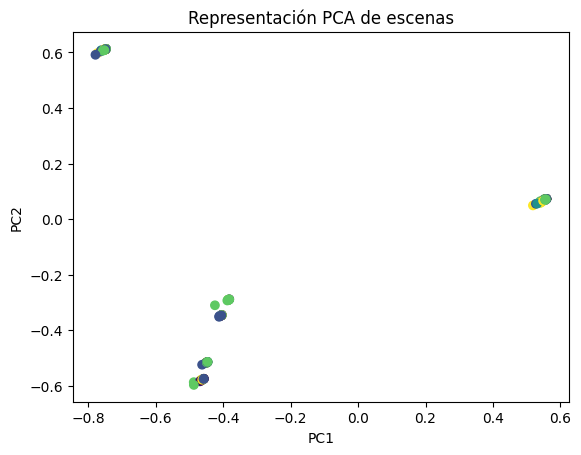

In [21]:
columnas_emocion = list(df.columns[df.columns.str.startswith('em_')])
X = df[['norm_longitud', 'norm_personajes'] + columnas_emocion]

selector = VarianceThreshold(threshold=0.01)
X_reduced = selector.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['tema_cluster'], cmap='viridis')
plt.title('Representaci√≥n PCA de escenas')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## Similitud entre escenas y personajes con embeddings

In [22]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# Se extraen las escenas y se generan nombres de escenas
escenas = df['escena_texto'].tolist()
nombres_escenas = [f'Escena {i+1}' for i in range(len(escenas))]

# Se carga el modelo y se generan los embeddings
model = SentenceTransformer('distiluse-base-multilingual-cased-v1')
embeddings = model.encode(escenas)

# Se calcula matriz de similitud
sim_matrix = cosine_similarity(embeddings)

# Se genera un dataframe temporal para desplegar los resultados de forma legible.
df_sim = pd.DataFrame(sim_matrix, index=nombres_escenas, columns=nombres_escenas)

In [23]:
import numpy as np
# Convertir la matriz en formato largo (pares de escena)
sim_pairs = df_sim.where(~np.eye(df_sim.shape[0], dtype=bool))  # Elimina la diagonal (1.0 de autocomparaci√≥n)
sim_pairs = sim_pairs.stack().reset_index()
sim_pairs.columns = ['Escena A', 'Escena B', 'Similaridad']

# Ordenar de mayor a menor
sim_pairs = sim_pairs.sort_values(by='Similaridad', ascending=False)

# Opcional: eliminar duplicados (Ej: A-B y B-A)
sim_pairs['Escenas'] = sim_pairs[['Escena A', 'Escena B']].apply(lambda x: tuple(sorted(x)), axis=1)
sim_pairs = sim_pairs.drop_duplicates(subset='Escenas').drop(columns='Escenas')

# Mostrar top 10 pares m√°s similares
print('10 escenas con mayor similitud:')
sim_pairs.head(10)

10 escenas con mayor similitud:


Escena A   Escena B  Similaridad
12986  Escena 62  Escena 55     1.000000
11082  Escena 53  Escena 60     1.000000
5317   Escena 26  Escena 18     0.979297
11721  Escena 56  Escena 63     0.977420
11295  Escena 54  Escena 61     0.963691
4055   Escena 20  Escena 29     0.960901
5742   Escena 28  Escena 19     0.879462
15976  Escena 76  Escena 78     0.827906
10868  Escena 52  Escena 58     0.817077
13412  Escena 64  Escena 57     0.798230

## Baseline usando el dataframe

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.feature_selection import SelectKBest, chi2

In [25]:
X_texto = df['escena_texto']
y = df['emocion']

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X_texto)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Entrenamiento del modelo baseline y evaluaci√≥n

In [26]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("\nReporte de clasificaci√≥n:\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.609375
F1 Score: 0.46146844660194175

Reporte de clasificaci√≥n:

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00         4
     disgust       0.00      0.00      0.00         1
        fear       0.61      1.00      0.76        39
         joy       0.00      0.00      0.00         8
     neutral       0.00      0.00      0.00         7
     sadness       0.00      0.00      0.00         5

    accuracy                           0.61        64
   macro avg       0.10      0.17      0.13        64
weighted avg       0.37      0.61      0.46        64



## Palabras m√°s relevantes seg√∫n chi-cuadrado

In [27]:
selector = SelectKBest(score_func=chi2, k=10)
selector.fit(X, y)
selected_words = np.array(vectorizer.get_feature_names_out())[selector.get_support()]
print("Palabras m√°s importantes seg√∫n chi2:", selected_words)

Palabras m√°s importantes seg√∫n chi2: ['carpentier' 'golpeado' 'hereje' 'impuesto' 'inquisici√≥n' 'insulta'
 'inuk' 'josefa' 'pregonero' 'virrey']


## Visualizaci√≥n PCA de escenas por emoci√≥n

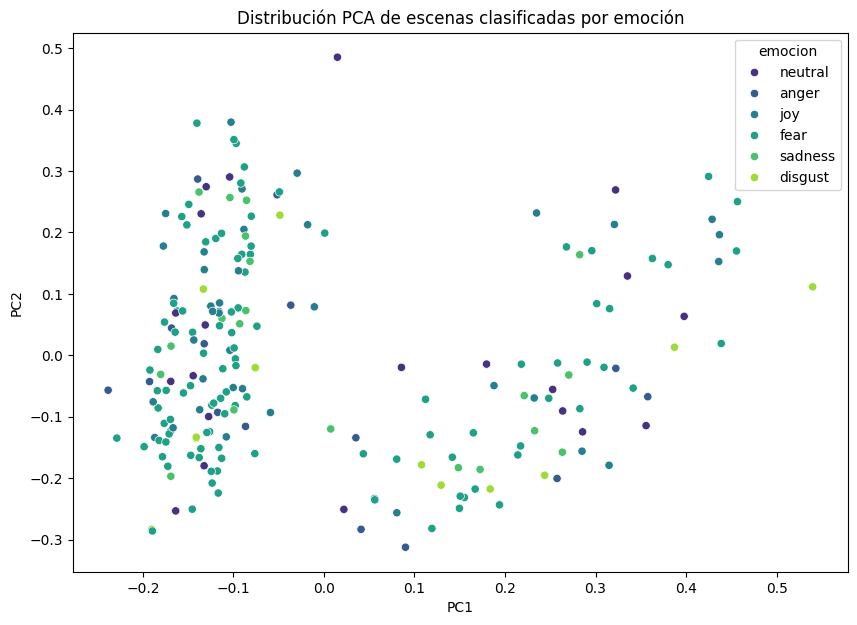

In [28]:
X_dense = X.toarray()
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_dense)

df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['emocion'] = y.values

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='emocion', palette='viridis')
plt.title("Distribuci√≥n PCA de escenas clasificadas por emoci√≥n")
plt.show()

## Validaci√≥n cruzada del modelo baseline

In [29]:
scores = cross_val_score(model, X, y, cv=5, scoring='f1_weighted')
print("F1 ponderado promedio (CV 5-fold):", np.mean(scores))

F1 ponderado promedio (CV 5-fold): 0.33079755515802023


## Preparaci√≥n de datos

In [30]:
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [31]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['escena_texto'])
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['emocion'])

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

## Entrenamiento de modelos individuales

In [32]:
modelos = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'MultinomialNB': MultinomialNB(),
    'RandomForest': RandomForestClassifier(),
    'KNeighbors': KNeighborsClassifier(),
    'SVC': SVC(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

resultados = []
for nombre, modelo in modelos.items():
    start = time.time()
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    duracion = time.time() - start
    resultados.append({
        'modelo': nombre,
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_macro': f1_score(y_test, y_pred, average='macro'),
        'f1_weighted': f1_score(y_test, y_pred, average='weighted'),
        'tiempo_seg': duracion
    })

## Comparativa de resultados

modelo  accuracy  f1_macro  f1_weighted  tiempo_seg
5             XGBoost  0.515625  0.215570     0.484408    4.271868
3          KNeighbors  0.421875  0.163889     0.401302    0.004970
4                 SVC  0.609375  0.162450     0.486317    0.131993
2        RandomForest  0.593750  0.154882     0.478220    0.937017
1       MultinomialNB  0.609375  0.126214     0.461468    0.002999
0  LogisticRegression  0.609375  0.126214     0.461468    1.653068

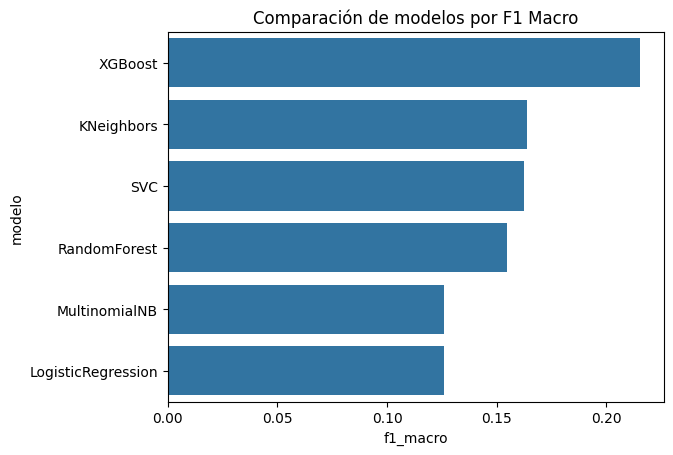

In [33]:
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by='f1_macro', ascending=False)
display(df_resultados)

sns.barplot(x='f1_macro', y='modelo', data=df_resultados)
plt.title('Comparaci√≥n de modelos por F1 Macro')
plt.show()

## Ajuste fino de los dos mejores modelos

In [34]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

param_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1]
}

grid_xgb = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    param_grid=param_xgb,
    scoring='f1_macro',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_xgb.fit(X_train, y_train)
print("Mejor score (XGBoost):", grid_xgb.best_score_)
print("Mejores par√°metros:", grid_xgb.best_params_)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Mejor score (XGBoost): 0.19772866461671015
Mejores par√°metros: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 50, 'subsample': 1}


In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_knn,
    scoring='f1_macro',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_knn.fit(X_train, y_train)
print("Mejor score (KNN):", grid_knn.best_score_)
print("Mejores par√°metros:", grid_knn.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Mejor score (KNN): 0.24258203920137658
Mejores par√°metros: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}


## Elecci√≥n del modelo final

### ‚úÖ Ajuste de Modelos y Selecci√≥n Final

#### üîß Modelos seleccionados para ajuste fino

Se eligieron los dos modelos con mejor desempe√±o en F1 Macro antes del ajuste:

| Modelo         | F1 Macro (antes) |
|----------------|------------------|
| XGBoost        | 0.2156           |
| KNeighbors     | 0.1639           |

---

#### üî¨ Resultados tras el ajuste de hiperpar√°metros

**XGBoost (ajustado):**

- **Mejor F1 Macro:** 0.1977
- **Hiperpar√°metros √≥ptimos:**
  - `learning_rate`: 0.01
  - `max_depth`: 10
  - `n_estimators`: 50
  - `subsample`: 1
- üî¥ No mejor√≥ respecto al modelo original.

**KNeighborsClassifier (ajustado):**

- **Mejor F1 Macro:** **0.2426**
- **Hiperpar√°metros √≥ptimos:**
  - `n_neighbors`: 7
  - `weights`: 'distance'
  - `metric`: 'euclidean'
- ‚úÖ Mejor√≥ significativamente con respecto al modelo original.

---

#### üèÅ Modelo final seleccionado: **KNeighborsClassifier (ajustado)**

##### ‚úÖ Justificaci√≥n t√©cnica:
- Mayor mejora en la m√©trica principal (F1 Macro).
- Bajo tiempo de entrenamiento.
- Captura bien la **similitud sem√°ntica entre escenas** vectorizadas con TF-IDF.

##### üé¨ Justificaci√≥n narrativa:
- Permite encontrar escenas similares emocionalmente, ideal para la **curadur√≠a de bloques emocionales** en la producci√≥n del tr√°iler.
- Favorece la **consistencia narrativa** al agrupar escenas por cercan√≠a de tono y tema.

---

Este modelo ser√° utilizado como base para las siguientes fases del proyecto, en particular para la automatizaci√≥n de la selecci√≥n de escenas con carga emocional espec√≠fica.